In [ ]:
import argparse
import gym
from gym import wrappers
import os.path as osp
import random
import numpy as np
import itertools
import tensorflow as tf
import tensorflow.contrib.layers as layers
import time

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import plotting

import dqn
from dqn_utils import *
#from atari_wrappers import *
#from environments.arm_env.arm_env import ArmEnv
from arm_env_dqn_go_down import ArmEnvDQN_1

In [2]:

def arm_model(img_in, num_actions, scope, reuse=False):
    # as described in https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
    with tf.variable_scope(scope, reuse=reuse):
        out = img_in
        with tf.variable_scope("convnet"):
            # original architecture
            out = layers.convolution2d(out, num_outputs=32, kernel_size=8, stride=4, activation_fn=tf.nn.relu)
            out = layers.convolution2d(out, num_outputs=64, kernel_size=4, stride=2, activation_fn=tf.nn.relu)
            out = layers.convolution2d(out, num_outputs=64, kernel_size=3, stride=1, activation_fn=tf.nn.relu)
        out = layers.flatten(out)
        with tf.variable_scope("action_value"):
            out = layers.fully_connected(out, num_outputs=256,         activation_fn=tf.nn.relu)
            out = layers.fully_connected(out, num_outputs=num_actions, activation_fn=None)

        return out


def arm_learn(env, session, num_timesteps):
    # This is just a rough estimate
    num_iterations = float(num_timesteps) / 4.0

    lr_multiplier = 1.0
    lr_schedule = PiecewiseSchedule([
                                         (0,                   1e-4 * lr_multiplier),
                                         (num_iterations / 10, 1e-4 * lr_multiplier),
                                         (num_iterations / 2,  5e-5 * lr_multiplier),
                                    ],
                                    outside_value=5e-5 * lr_multiplier)
    optimizer = dqn.OptimizerSpec(
        constructor=tf.train.AdamOptimizer,
        kwargs=dict(epsilon=1e-4),
        lr_schedule=lr_schedule
    )

    def stopping_criterion(env, t):
        # notice that here t is the number of steps of the wrapped env,
        # which is different from the number of steps in the underlying env
        return t >= num_timesteps

    exploration_schedule = PiecewiseSchedule(
        [
            (0, 1.0),
            (8e3, 0.3),
            (num_iterations, 0.01),
        ], outside_value=0.01
    )

    dqn.learn(
        env,
        q_func=arm_model,
        optimizer_spec=optimizer,
        session=session,
        exploration=exploration_schedule,
        stopping_criterion=stopping_criterion,
        replay_buffer_size=1000000,
        batch_size=32,
        gamma=0.99,
        learning_starts=5000,
        learning_freq=1,
        frame_history_len=1,
        target_update_freq=200,
        grad_norm_clipping=10
    )
    
    ep_rew = env.get_episode_rewards()
    ep_len = env.get_episode_lengths()
    env.close()
    return ep_rew, ep_len

def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

def set_global_seeds(i):
    try:
        import tensorflow as tf
    except ImportError:
        pass
    else:
        tf.set_random_seed(i) 
    np.random.seed(i)
    random.seed(i)

def get_session():
    tf.reset_default_graph()
#     tf_config = tf.ConfigProto(
#         inter_op_parallelism_threads=1,
#         intra_op_parallelism_threads=1)
    session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    print("AVAILABLE GPUS: ", get_available_gpus())
    session = tf.Session()
    return session



AVAILABLE GPUS:  []
Timestep 5500
mean reward (50 episodes) 88.740000
mean length (50 episodes) 11.260000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 38.000000
max_episode_length (50 episodes) 62.000000
best mean reward 95.000000
episodes 173
exploration 0.518750
learning_rate 0.000099


Timestep 6000
mean reward (50 episodes) 91.660000
mean length (50 episodes) 8.340000
max_episode_reward (50 episodes) 97.000000
min_episode_length (50 episodes) 3.000000
min_episode_reward (50 episodes) 73.000000
max_episode_length (50 episodes) 27.000000
best mean reward 95.000000
episodes 229
exploration 0.475000
learning_rate 0.000097


Timestep 6500
mean reward (50 episodes) 93.580000
mean length (50 episodes) 6.420000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 84.000000
max_episode_length (50 episodes) 16.000000
best mean reward 95.000000
episodes 302

Timestep 17500
mean reward (50 episodes) 95.020000
mean length (50 episodes) 4.980000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 91.000000
max_episode_length (50 episodes) 9.000000
best mean reward 95.360000
episodes 2164
exploration 0.234405
learning_rate 0.000069


Timestep 18000
mean reward (50 episodes) 95.220000
mean length (50 episodes) 4.780000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 91.000000
max_episode_length (50 episodes) 9.000000
best mean reward 95.360000
episodes 2263
exploration 0.230952
learning_rate 0.000068


Timestep 18500
mean reward (50 episodes) 95.140000
mean length (50 episodes) 4.860000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 91.000000
max_episode_length (50 episodes) 9.000000
best mean reward 95.360000
episodes 2361
exploration 0.227

Timestep 29500
mean reward (50 episodes) 95.380000
mean length (50 episodes) 4.620000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 92.000000
max_episode_length (50 episodes) 8.000000
best mean reward 95.700000
episodes 4641
exploration 0.151548
learning_rate 0.000050


Timestep 30000
mean reward (50 episodes) 95.640000
mean length (50 episodes) 4.360000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 93.000000
max_episode_length (50 episodes) 7.000000
best mean reward 95.820000
episodes 4753
exploration 0.148095
learning_rate 0.000050


Timestep 30500
mean reward (50 episodes) 95.340000
mean length (50 episodes) 4.660000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 90.000000
max_episode_length (50 episodes) 10.000000
best mean reward 95.820000
episodes 4861
exploration 0.14

Timestep 41500
mean reward (50 episodes) 95.500000
mean length (50 episodes) 4.500000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 90.000000
max_episode_length (50 episodes) 10.000000
best mean reward 96.040000
episodes 7313
exploration 0.068690
learning_rate 0.000050


Timestep 42000
mean reward (50 episodes) 95.600000
mean length (50 episodes) 4.400000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 92.000000
max_episode_length (50 episodes) 8.000000
best mean reward 96.040000
episodes 7429
exploration 0.065238
learning_rate 0.000050


Timestep 42500
mean reward (50 episodes) 95.760000
mean length (50 episodes) 4.240000
max_episode_reward (50 episodes) 97.000000
min_episode_length (50 episodes) 3.000000
min_episode_reward (50 episodes) 93.000000
max_episode_length (50 episodes) 7.000000
best mean reward 96.040000
episodes 7546
exploration 0.06

Timestep 53500
mean reward (50 episodes) 96.140000
mean length (50 episodes) 3.860000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.260000
episodes 10222
exploration 0.010000
learning_rate 0.000050


Timestep 54000
mean reward (50 episodes) 95.940000
mean length (50 episodes) 4.060000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.260000
episodes 10345
exploration 0.010000
learning_rate 0.000050


Timestep 54500
mean reward (50 episodes) 95.780000
mean length (50 episodes) 4.220000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.260000
episodes 10468
exploration 0.

Timestep 65500
mean reward (50 episodes) 96.240000
mean length (50 episodes) 3.760000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.400000
episodes 13218
exploration 0.010000
learning_rate 0.000050


Timestep 66000
mean reward (50 episodes) 96.060000
mean length (50 episodes) 3.940000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.400000
episodes 13344
exploration 0.010000
learning_rate 0.000050


Timestep 66500
mean reward (50 episodes) 96.160000
mean length (50 episodes) 3.840000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.400000
episodes 13473
exploration 0.

Timestep 77500
mean reward (50 episodes) 96.240000
mean length (50 episodes) 3.760000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.460000
episodes 16285
exploration 0.010000
learning_rate 0.000050


Timestep 78000
mean reward (50 episodes) 96.320000
mean length (50 episodes) 3.680000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.460000
episodes 16418
exploration 0.010000
learning_rate 0.000050


Timestep 78500
mean reward (50 episodes) 96.060000
mean length (50 episodes) 3.940000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.460000
episodes 16546
exploration 0.

Timestep 89500
mean reward (50 episodes) 96.220000
mean length (50 episodes) 3.780000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.520000
episodes 19436
exploration 0.010000
learning_rate 0.000050


Timestep 90000
mean reward (50 episodes) 96.220000
mean length (50 episodes) 3.780000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 93.000000
max_episode_length (50 episodes) 7.000000
best mean reward 96.520000
episodes 19565
exploration 0.010000
learning_rate 0.000050


Timestep 90500
mean reward (50 episodes) 96.340000
mean length (50 episodes) 3.660000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.520000
episodes 19697
exploration 0.

Timestep 101500
mean reward (50 episodes) 96.080000
mean length (50 episodes) 3.920000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.540000
episodes 22570
exploration 0.010000
learning_rate 0.000050


Timestep 102000
mean reward (50 episodes) 96.360000
mean length (50 episodes) 3.640000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.540000
episodes 22706
exploration 0.010000
learning_rate 0.000050


Timestep 102500
mean reward (50 episodes) 96.200000
mean length (50 episodes) 3.800000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.540000
episodes 22837
exploration

Timestep 113500
mean reward (50 episodes) 96.260000
mean length (50 episodes) 3.740000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 25774
exploration 0.010000
learning_rate 0.000050


Timestep 114000
mean reward (50 episodes) 96.400000
mean length (50 episodes) 3.600000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 25910
exploration 0.010000
learning_rate 0.000050


Timestep 114500
mean reward (50 episodes) 96.160000
mean length (50 episodes) 3.840000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.640000
episodes 26046
exploration

Timestep 125500
mean reward (50 episodes) 96.060000
mean length (50 episodes) 3.940000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.640000
episodes 28971
exploration 0.010000
learning_rate 0.000050


Timestep 126000
mean reward (50 episodes) 96.300000
mean length (50 episodes) 3.700000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 29105
exploration 0.010000
learning_rate 0.000050


Timestep 126500
mean reward (50 episodes) 96.440000
mean length (50 episodes) 3.560000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.640000
episodes 29240
exploration

Timestep 137500
mean reward (50 episodes) 96.300000
mean length (50 episodes) 3.700000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 32191
exploration 0.010000
learning_rate 0.000050


Timestep 138000
mean reward (50 episodes) 96.500000
mean length (50 episodes) 3.500000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 32326
exploration 0.010000
learning_rate 0.000050


Timestep 138500
mean reward (50 episodes) 96.300000
mean length (50 episodes) 3.700000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 32462
exploration

Timestep 149500
mean reward (50 episodes) 96.260000
mean length (50 episodes) 3.740000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.640000
episodes 35388
exploration 0.010000
learning_rate 0.000050


Timestep 150000
mean reward (50 episodes) 96.500000
mean length (50 episodes) 3.500000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 35522
exploration 0.010000
learning_rate 0.000050


Timestep 150500
mean reward (50 episodes) 96.240000
mean length (50 episodes) 3.760000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.640000
episodes 35653
exploration

Timestep 161500
mean reward (50 episodes) 96.320000
mean length (50 episodes) 3.680000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 38605
exploration 0.010000
learning_rate 0.000050


Timestep 162000
mean reward (50 episodes) 96.440000
mean length (50 episodes) 3.560000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 38740
exploration 0.010000
learning_rate 0.000050


Timestep 162500
mean reward (50 episodes) 96.320000
mean length (50 episodes) 3.680000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 38874
exploration

Timestep 173500
mean reward (50 episodes) 96.240000
mean length (50 episodes) 3.760000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 41789
exploration 0.010000
learning_rate 0.000050


Timestep 174000
mean reward (50 episodes) 96.160000
mean length (50 episodes) 3.840000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.640000
episodes 41922
exploration 0.010000
learning_rate 0.000050


Timestep 174500
mean reward (50 episodes) 96.360000
mean length (50 episodes) 3.640000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 42063
exploration

Timestep 185500
mean reward (50 episodes) 96.360000
mean length (50 episodes) 3.640000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 44977
exploration 0.010000
learning_rate 0.000050


Timestep 186000
mean reward (50 episodes) 96.380000
mean length (50 episodes) 3.620000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 45112
exploration 0.010000
learning_rate 0.000050


Timestep 186500
mean reward (50 episodes) 96.460000
mean length (50 episodes) 3.540000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 96.000000
max_episode_length (50 episodes) 4.000000
best mean reward 96.640000
episodes 45246
exploration

Timestep 197500
mean reward (50 episodes) 96.240000
mean length (50 episodes) 3.760000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 93.000000
max_episode_length (50 episodes) 7.000000
best mean reward 96.640000
episodes 48195
exploration 0.010000
learning_rate 0.000050


Timestep 198000
mean reward (50 episodes) 96.420000
mean length (50 episodes) 3.580000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 94.000000
max_episode_length (50 episodes) 6.000000
best mean reward 96.640000
episodes 48330
exploration 0.010000
learning_rate 0.000050


Timestep 198500
mean reward (50 episodes) 96.180000
mean length (50 episodes) 3.820000
max_episode_reward (50 episodes) 98.000000
min_episode_length (50 episodes) 2.000000
min_episode_reward (50 episodes) 95.000000
max_episode_length (50 episodes) 5.000000
best mean reward 96.640000
episodes 48464
exploration

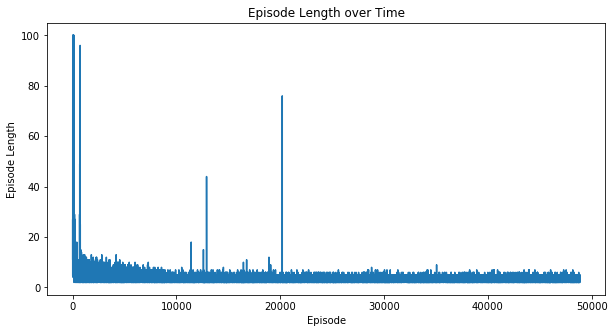

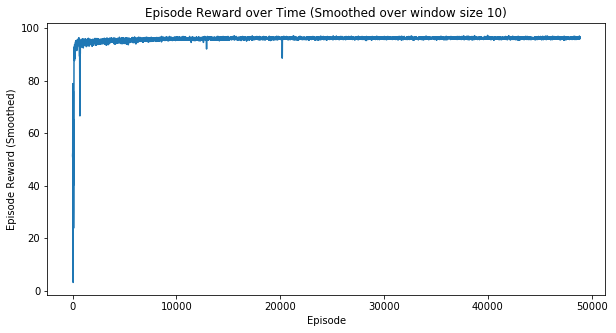

In [3]:
def main():
    # Get Atari games.
    # benchmark = gym.benchmark_spec('Atari40M')
    #
    # # Change the index to select a different game.
    # task = benchmark.tasks[3]
    #
    # # Run training
#     seed = 0  # Use a seed of zero (you may want to randomize the seed!)
#     set_global_seeds(seed)
    # env = get_env(task, seed)
    env = ArmEnvDQN_1(episode_max_length=100,
                 size_x=6,
                 size_y=4,
                 cubes_cnt=4,
                 scaling_coeff=3,
                 action_minus_reward=-1,
                 finish_reward=100,
                 tower_target_size=4)

    session = get_session()
                
    start = time.time()
    ep_rew, ep_len = arm_learn(env, session, num_timesteps=200000)
    end = time.time()
    print((end - start)/60)
    
    stats = plotting.EpisodeStats(
        episode_lengths=ep_len,
        episode_rewards=ep_rew)
    plotting.plot_episode_stats(stats)
#     tf.summary.FileWriter("option1_logs", tf.get_default_graph()).close()

if __name__ == "__main__":
    main()

In [ ]:
def encode_observation(frame):
    img_h, img_w = frame.shape[1], frame.shape[2]
    return frame.transpose(1, 2, 0, 3).reshape(img_h, img_w, -1)

def main():
    env = ArmEnvDQN(episode_max_length=200,
                 size_x=5,
                 size_y=5,
                 cubes_cnt=4,
                 scaling_coeff=3,
                 action_minus_reward=-1,
                 finish_reward=400,
                 tower_target_size=4)
    # print(env.reset())
    session = tf.Session()
    # First let's load meta graph and restore weights
    saver = tf.train.import_meta_graph('option_go_down.meta')
    saver.restore(session, tf.train.latest_checkpoint('./'))
    frame_history_len = 1
    img_h, img_w, img_c = env.observation_space.shape
    input_shape = (img_h, img_w, frame_history_len * img_c)  # size_x, size_y,
    num_actions = env.action_space.n

#     # placeholder for current observation (or state)
#     obs_t_ph = tf.placeholder(tf.uint8, [None] + list(input_shape))
#     # casting to float on GPU ensures lower data transfer times.
#     obs_t_float = tf.cast(obs_t_ph, tf.float32) / 255.0



#     pred_q = q_func(obs_t_float, num_actions, scope="q_func", reuse=False)
#     pred_ac = tf.argmax(pred_q, axis=1)
    graph = tf.get_default_graph()

    obs_t_float = graph.get_tensor_by_name("obs_t_ph:0")
 
    ## How to access saved operation
    pred_ac = graph.get_tensor_by_name("pred_ac:0")
    
    
    episode_reward = 0
    episode_length = 0
    last_obs = env.reset()

    for t in itertools.count():

        obs = encode_observation(np.array([last_obs]))
        action = session.run(pred_ac, {obs_t_float: [obs]})[0]

        next_obs, reward, done, info = env.step(action)

        episode_reward += reward
        episode_length += 1

        if done or episode_length == 500:
            break

        last_obs = next_obs
    print(episode_reward, episode_length)


if __name__ == "__main__":
    main()